In [50]:
import os
from os import listdir
from os.path import isfile, join
from typing import Dict, List
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from hipe_commons.own_helpers import tsv_to_dataframe, get_newsag_df
from hipe_commons.helpers.tsv import parse_tsv, ENTITY_TYPES, HipeDocument
from hipe_commons.stats import describe_dataset

# Create Dataframe for Stats

In [51]:
docs_de_dir = "../../data/annotated_retok_autosegment/de/tsv-corrected/"
docs_fr_dir = "../../data/annotated_retok_autosegment/fr/tsv-corrected/"

split_de_path = "../../data/data_info/train-dev-test_de.csv"
split_fr_path = "../../data/data_info/train-dev-test_fr.csv"

docs_de = [f for f in listdir(docs_de_dir) if isfile(join(docs_de_dir, f))]
docs_fr = [f for f in listdir(docs_fr_dir) if isfile(join(docs_fr_dir, f))]

In [52]:
#import information on split
split_de = pd.read_csv(split_de_path).set_index("uid")
split_fr = pd.read_csv(split_fr_path).set_index("uid")

#some articles were wrongly classified as French
luxworts = ["luxwort-1849-06-03-a-i0008", "luxwort-1849-07-15-a-i0002", "luxwort-1850-05-12-a-i0004", "luxwort-1853-11-27-a-i0001", "luxwort-1858-02-26-a-i0009", "luxwort-1858-11-25-a-i0009"]
if luxworts[0] in split_fr.index:
    split_de = pd.concat([split_de, split_fr.loc[luxworts]])
    split_fr = split_fr.drop(luxworts)
    #save changes
    split_de.to_csv(split_de_path)
    split_fr.to_csv(split_fr_path)

    if (luxworts[0] in split_de.index) and (luxworts[0] not in split_fr.index):
        print("Transfer of Luxwort articles completed.")

split_fr.head(2)

,Unnamed: 0,split
uid,,
JDG-1946-11-23-a-i0128,1057,train
IMP-1949-02-04-a-i0155,1039,train


In [53]:
def make_stats_rows(cur_df, annotation_planning):

    mentions = {col: [] for col in ["document_id", "year", "decade", "newspaper", "document_size", "language", "split",
                              "ag_mention", "ag_position", "ag_at_beginning", "ag_at_end",
                              "levenshtein_dist"]}
    
    no_mention = {col: [] for col in ["document_id", "year", "decade", "newspaper", "document_size", "language", "split"]}
    
    doc_id = cur_df["document_id"].values[0]

    if cur_df["news-agency-as-source"].values[0] == "_":
        no_mention["document_id"].append(cur_df["document_id"].values[0])

        year = int(cur_df["date"].values[0][:4])
        no_mention["year"].append(year)
        no_mention["decade"].append(int(year//10 * 10))

        no_mention["newspaper"].append(cur_df["newspaper"].values[0])
        no_mention["document_size"].append(len(cur_df))
        no_mention["language"].append(cur_df["language"].values[0])
        no_mention["split"].append(annotation_planning.loc[doc_id, "split"])
    
    else:
        doc_size = len(cur_df)
        mention_rows = cur_df[cur_df["NE-FINE-LIT"].str.startswith("B-org")]

        for mention_n in list(mention_rows["n"]):
            mention_row = cur_df[cur_df["n"] == mention_n]
            mention_position = mention_n - 6

            mentions["document_id"].append(cur_df["document_id"].values[0])

            year = int(cur_df["date"].values[0][:4])
            mentions["year"].append(year)
            mentions["decade"].append(int(year//10 * 10))

            mentions["newspaper"].append(cur_df["newspaper"].values[0])
            mentions["document_size"].append(doc_size)
            mentions["language"].append(cur_df["language"].values[0])
            mentions["split"].append(annotation_planning.loc[doc_id, "split"])
            mentions["ag_mention"].append(mention_row["NE-FINE-LIT"].values[0].split(".")[-1])
            mentions["ag_position"].append(mention_position)
            mentions["ag_at_beginning"].append(bool(mention_position < 10))
            mentions["ag_at_end"].append(bool(mention_position > (doc_size - 10)))
            mentions["levenshtein_dist"].append(float(mention_row["OCR-INFO"].values[0].split("|")[-1][3:]))

    return pd.DataFrame(mentions), pd.DataFrame(no_mention)


## one row per mention

In [54]:
no_mention_de = pd.DataFrame()
mentions_de = pd.DataFrame()

for doc in docs_de:
    doc_path = join(docs_de_dir, doc)
    cur_df = tsv_to_dataframe(doc_path, keep_comments=True, hipe_format_version="v2")
    mentions_rows, no_mention_row = make_stats_rows(cur_df, split_de)
    mentions_de, no_mention_de = pd.concat([mentions_de, mentions_rows]), pd.concat([no_mention_de, no_mention_row])
    

C:\Users\Lea\AppData\Local\Temp\ipykernel_8616\2334823962.py:8: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  mentions_de, no_mention_de = pd.concat([mentions_de, mentions_rows]), pd.concat([no_mention_de, no_mention_row])


In [55]:
no_mention_fr = pd.DataFrame()
mentions_fr = pd.DataFrame()

for doc in docs_fr:
    doc_path = join(docs_fr_dir, doc)
    cur_df = tsv_to_dataframe(doc_path, keep_comments=True, hipe_format_version="v2")
    mentions_rows, no_mention_row = make_stats_rows(cur_df, split_fr)
    mentions_fr, no_mention_fr = pd.concat([mentions_fr, mentions_rows]), pd.concat([no_mention_fr, no_mention_row])
    

C:\Users\Lea\AppData\Local\Temp\ipykernel_8616\1013314241.py:8: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  mentions_fr, no_mention_fr = pd.concat([mentions_fr, mentions_rows]), pd.concat([no_mention_fr, no_mention_row])


In [56]:
#decade column to integer
no_mention_de["decade"] = no_mention_de["decade"].astype(int)
no_mention_fr["decade"] = no_mention_fr["decade"].astype(int)
mentions_fr["decade"] = mentions_fr["decade"].astype(int)
mentions_de["decade"] = mentions_de["decade"].astype(int)

#new column: agency_in_middle
mentions_fr["ag_in_middle"] = mentions_fr["ag_at_end"] + mentions_fr["ag_at_beginning"]
mentions_fr["ag_in_middle"] = mentions_fr["ag_in_middle"].apply(lambda row: 0 if row > 0 else 1)
mentions_de["ag_in_middle"] = mentions_de["ag_at_end"] + mentions_de["ag_at_beginning"]
mentions_de["ag_in_middle"] = mentions_de["ag_in_middle"].apply(lambda row: 0 if row > 0 else 1)

In [57]:
no_mention_de.head()

,document_id,year,decade,newspaper,document_size,language,split
0,buergerbeamten-1902-07-15-a-i0007,1902.0,1900,buergerbeamten,2140.0,de,train
0,buergerbeamten-1904-06-02-a-i0003,1904.0,1900,buergerbeamten,278.0,de,train
0,buergerbeamten-1904-06-14-a-i0011,1904.0,1900,buergerbeamten,859.0,de,train
0,buergerbeamten-1905-05-13-a-i0009,1905.0,1900,buergerbeamten,59.0,de,train
0,buergerbeamten-1907-01-24-a-i0008,1907.0,1900,buergerbeamten,1550.0,de,train


In [58]:
mentions_de.head()

,document_id,year,decade,newspaper,document_size,language,split,ag_mention,ag_position,ag_at_beginning,ag_at_end,levenshtein_dist,ag_in_middle
0,buergerbeamten-1910-06-18-a-i0009,1910.0,1910,buergerbeamten,487.0,de,train,Wolff,423.0,0.0,0.0,0.15,1
0,buergerbeamten-1915-12-14-a-i0006,1915.0,1910,buergerbeamten,65.0,de,train,Havas,6.0,1.0,0.0,0.00,0
1,buergerbeamten-1915-12-14-a-i0006,1915.0,1910,buergerbeamten,65.0,de,train,Havas,60.0,0.0,1.0,0.00,0
0,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,train,UP-UPI,61.0,0.0,0.0,0.00,1
1,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,train,Extel,537.0,0.0,0.0,0.00,1


In [59]:
mentions_de_ag_cols = pd.get_dummies(mentions_de, prefix="", prefix_sep="", columns=["ag_mention"])
mentions_fr_ag_cols = pd.get_dummies(mentions_fr, prefix="", prefix_sep="", columns=["ag_mention"])

mentions_fr_ag_cols.head(1)

,document_id,year,decade,newspaper,document_size,language,split,ag_position,ag_at_beginning,ag_at_end,...,Havas,Kipa,Reuters,Stefani,TASS,UP-UPI,Wolff,Xinhua,ag,unk
0,avenirgdl-1869-09-20-a-i0002,1869.0,1860,avenirgdl,144.0,fr,train,38.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


## one row per article

In [60]:
articles_de = mentions_de.groupby(["document_id", "year", "decade", "newspaper", "document_size", 
                                              "language"]).agg(list).reset_index()
articles_fr = mentions_fr.groupby(["document_id", "year", "decade", "newspaper", "document_size", 
                                              "language"]).agg(list).reset_index()

In [61]:
articles_de.head()

,document_id,year,decade,newspaper,document_size,language,split,ag_mention,ag_position,ag_at_beginning,ag_at_end,levenshtein_dist,ag_in_middle
0,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,"[train, train, train, train, train, train]","[UP-UPI, Extel, DNB, Extel, Extel, Extel]","[61.0, 537.0, 625.0, 867.0, 1462.0, 1553.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.25, 0.0, 0.12]","[1, 1, 1, 1, 1, 0]"
1,DTT-1943-06-05-a-i0036,1943.0,1940,DTT,1811.0,de,"[train, train, train, train, train, train]","[Extel, UP-UPI, ag, DNB, Reuters, Extel]","[203.0, 382.0, 656.0, 730.0, 898.0, 1134.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.25, 0.0, 0.5, 0.0]","[1, 1, 1, 1, 1, 1]"
2,DTT-1943-07-20-a-i0033,1943.0,1940,DTT,552.0,de,"[train, train, train]","[UP-UPI, Extel, UP-UPI]","[79.0, 253.0, 474.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1, 1, 1]"
3,DTT-1943-09-30-a-i0009,1943.0,1940,DTT,1225.0,de,"[test, test, test, test, test, test, test, tes...","[UP-UPI, Extel, DNB, ag, Reuters, Reuters, DNB...","[25.0, 531.0, 621.0, 780.0, 859.0, 973.0, 1068...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
4,DTT-1945-08-09-a-i0008,1945.0,1940,DTT,303.0,de,"[dev, dev]","[Extel, UP-UPI]","[150.0, 241.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[1, 1]"


In [62]:
articles_de_ag_cols = mentions_de_ag_cols.groupby(["document_id", "year", "decade", "newspaper", "document_size", 
                                              "language"]).agg(sum).reset_index().drop("ag_position", axis=1)
articles_fr_ag_cols = mentions_fr_ag_cols.groupby(["document_id", "year", "decade", "newspaper", "document_size", 
                                              "language"]).agg(sum).reset_index().drop("ag_position", axis=1)

articles_de_ag_cols.head()

C:\Users\Lea\AppData\Local\Temp\ipykernel_8616\502139093.py:2: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  "language"]).agg(sum).reset_index().drop("ag_position", axis=1)
C:\Users\Lea\AppData\Local\Temp\ipykernel_8616\502139093.py:4: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  "language"]).agg(sum).reset_index().drop("ag_position", axis=1)


,document_id,year,decade,newspaper,document_size,language,ag_at_beginning,ag_at_end,levenshtein_dist,ag_in_middle,...,Extel,Havas,Kipa,Reuters,SPK-SMP,TASS,UP-UPI,Wolff,ag,unk
0,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,0.0,1.0,0.37,5,...,4,0,0,0,0,0,1,0,0,0
1,DTT-1943-06-05-a-i0036,1943.0,1940,DTT,1811.0,de,0.0,0.0,0.75,6,...,2,0,0,1,0,0,1,0,1,0
2,DTT-1943-07-20-a-i0033,1943.0,1940,DTT,552.0,de,0.0,0.0,0.00,3,...,1,0,0,0,0,0,2,0,0,0
3,DTT-1943-09-30-a-i0009,1943.0,1940,DTT,1225.0,de,0.0,1.0,0.33,9,...,1,0,0,3,0,0,1,0,2,0
4,DTT-1945-08-09-a-i0008,1945.0,1940,DTT,303.0,de,0.0,0.0,0.00,2,...,1,0,0,0,0,0,1,0,0,0


# Stats

## Agency distributions

In [63]:
decades = list(range(1840, 2000, 10))
print(decades)

[1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990]


In [64]:
ag_fr_index = list(mentions_fr_ag_cols.columns).index("AFP")
ag_fr = list(mentions_fr_ag_cols.columns[ag_fr_index:])

ag_de_index = list(mentions_de_ag_cols.columns).index("AFP")
ag_de = list(mentions_de_ag_cols.columns[ag_de_index:])

print(f"Agencies in German sample: {ag_de}\nAgencies in French sample: {ag_fr}")
print(f"not in German (but in French) sample: {set(ag_fr).difference(set(ag_de))}\nnot in French (but in German) sample: {set(ag_de).difference(set(ag_fr))}")

Agencies in German sample: ['AFP', 'AP', 'ATS-SDA', 'Belga', 'DDP-DAPD', 'DNB', 'DPA', 'Europapress', 'Extel', 'Havas', 'Kipa', 'Reuters', 'SPK-SMP', 'TASS', 'UP-UPI', 'Wolff', 'ag', 'unk']
Agencies in French sample: ['AFP', 'ANSA', 'AP', 'APA', 'ATS-SDA', 'Belga', 'CTK', 'DNB', 'DPA', 'Domei', 'Extel', 'Havas', 'Kipa', 'Reuters', 'Stefani', 'TASS', 'UP-UPI', 'Wolff', 'Xinhua', 'ag', 'unk']
not in German (but in French) sample: {'Stefani', 'Xinhua', 'APA', 'Domei', 'CTK', 'ANSA'}
not in French (but in German) sample: {'DDP-DAPD', 'SPK-SMP', 'Europapress'}


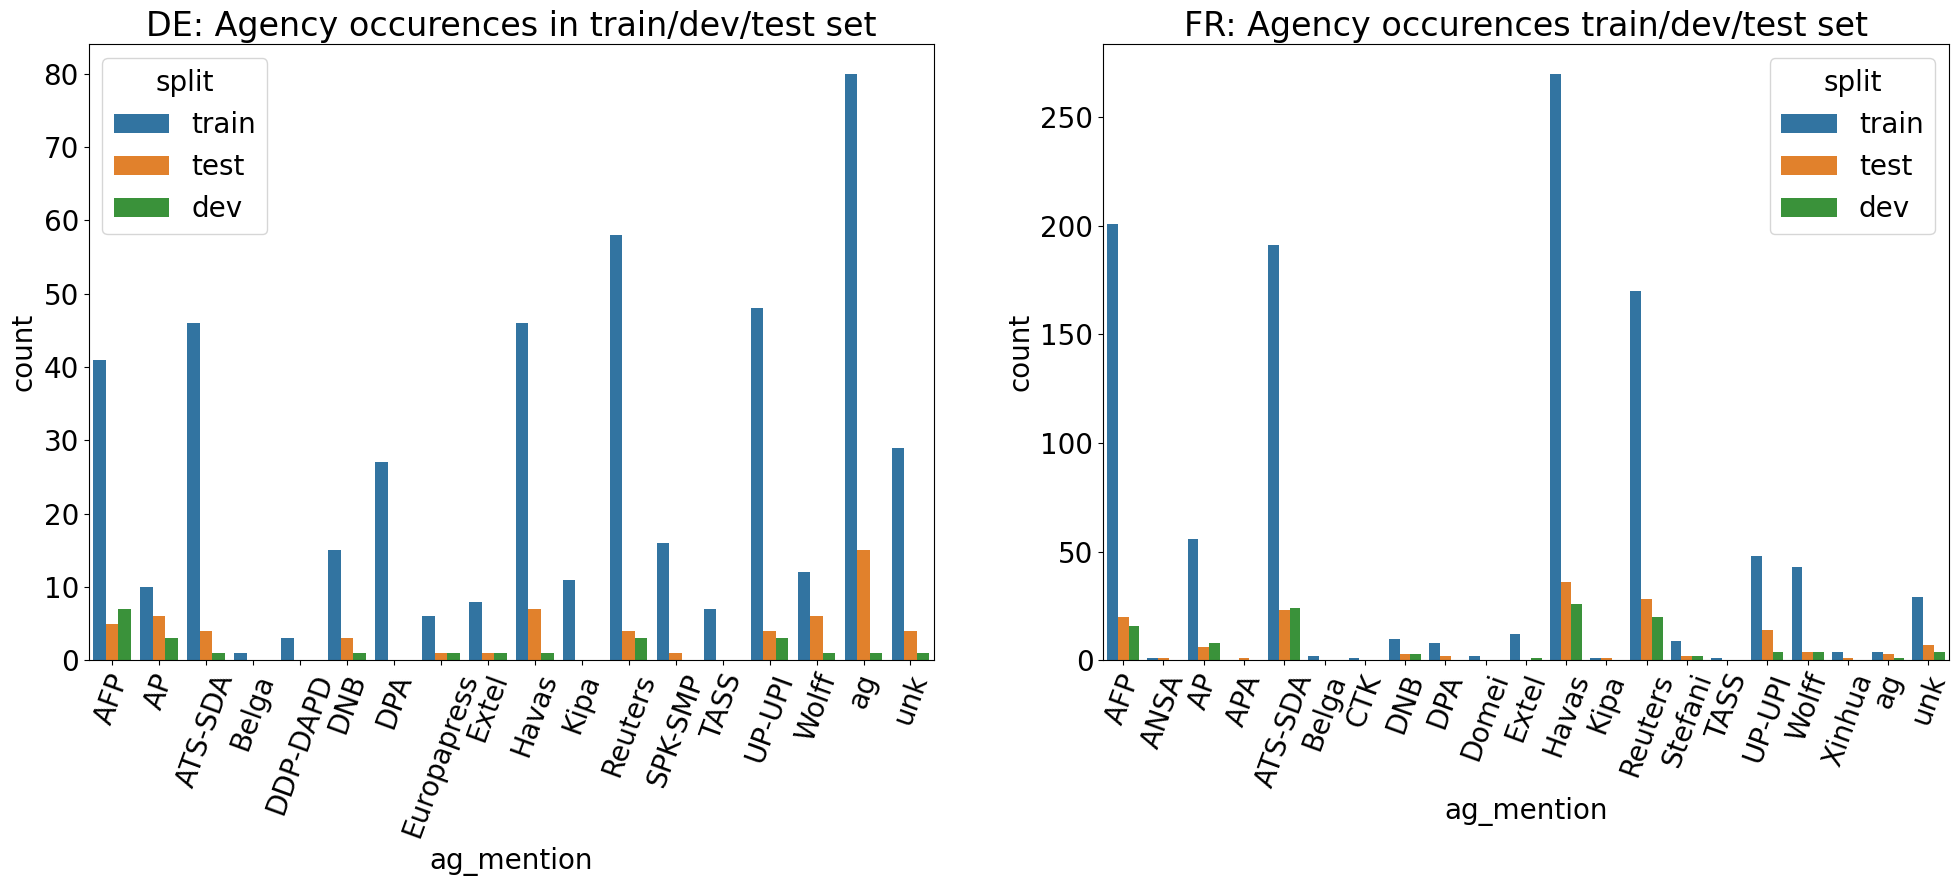

In [73]:
plt.rcParams.update({'font.size': 20})

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(24)
fig.set_figheight(8)

#plots
sns.countplot(x = "ag_mention", hue = "split", data = mentions_de, order=sorted(ag_de), ax=ax1)
sns.countplot(x = "ag_mention", hue = "split", data = mentions_fr, order=sorted(ag_fr), ax=ax2)

#layout
ax1.tick_params(axis="x", rotation=70)
ax2.tick_params(axis="x", rotation=70)
ax1.set_title("DE: Agency occurences in train/dev/test set")
ax2.set_title("FR: Agency occurences train/dev/test set")

plt.show()

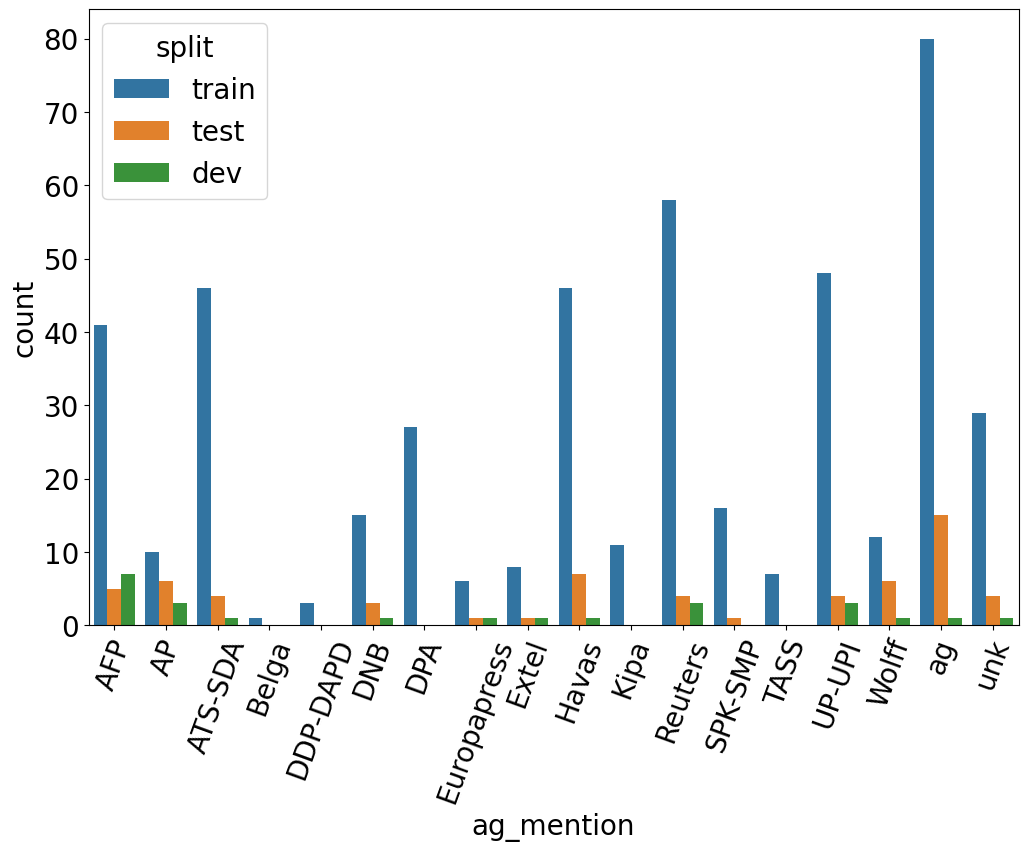

In [74]:
fig, ax1 = plt.subplots(1, figsize=(12,8))

#plots
sns.countplot(x = "ag_mention", hue = "split", data = mentions_de, order=sorted(ag_de), ax=ax1)

#layout
ax1.tick_params(axis="x", rotation=70)

plt.show()

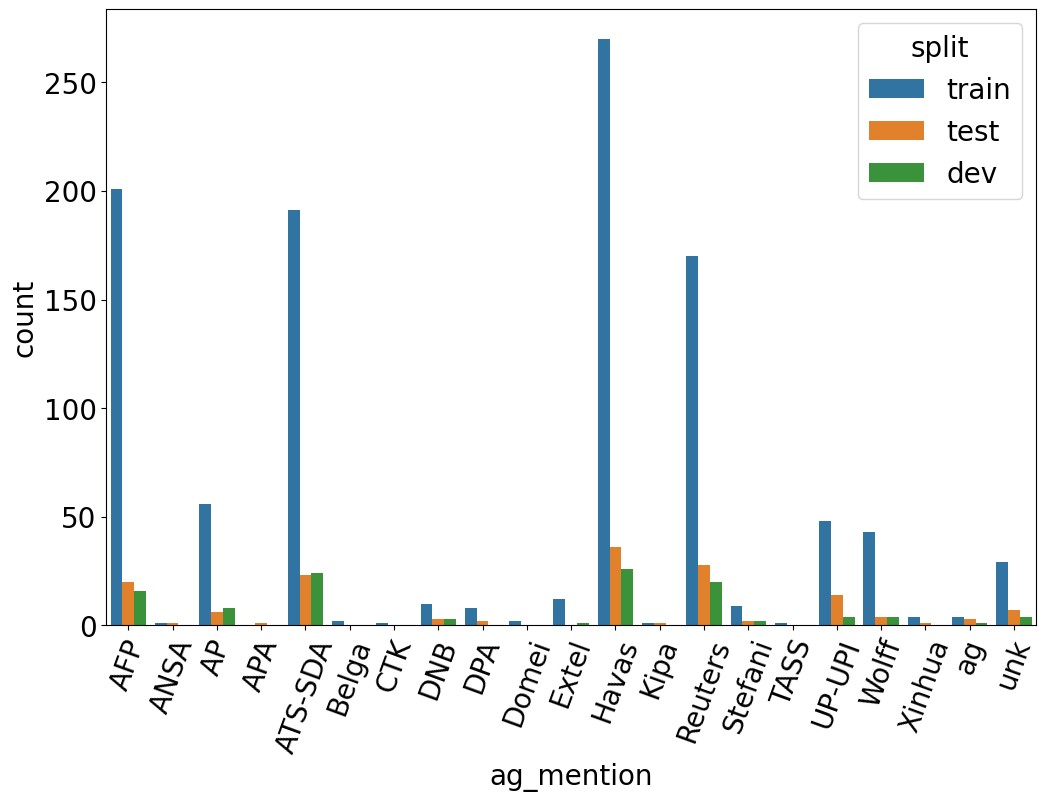

In [75]:
fig, ax1 = plt.subplots(1, figsize=(12,8))

#plots
sns.countplot(x = "ag_mention", hue = "split", data = mentions_fr, order=sorted(ag_fr), ax=ax1)

#layout
ax1.tick_params(axis="x", rotation=70)

plt.show()

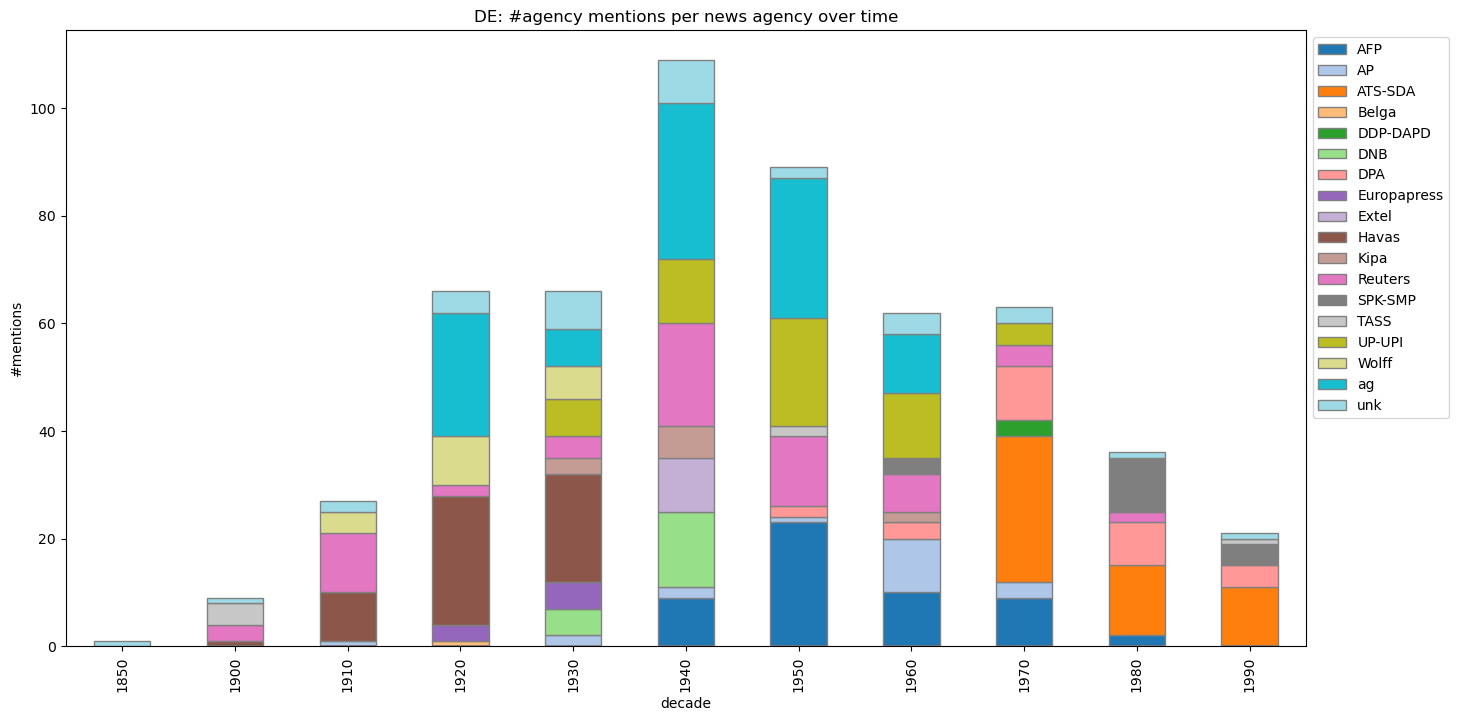

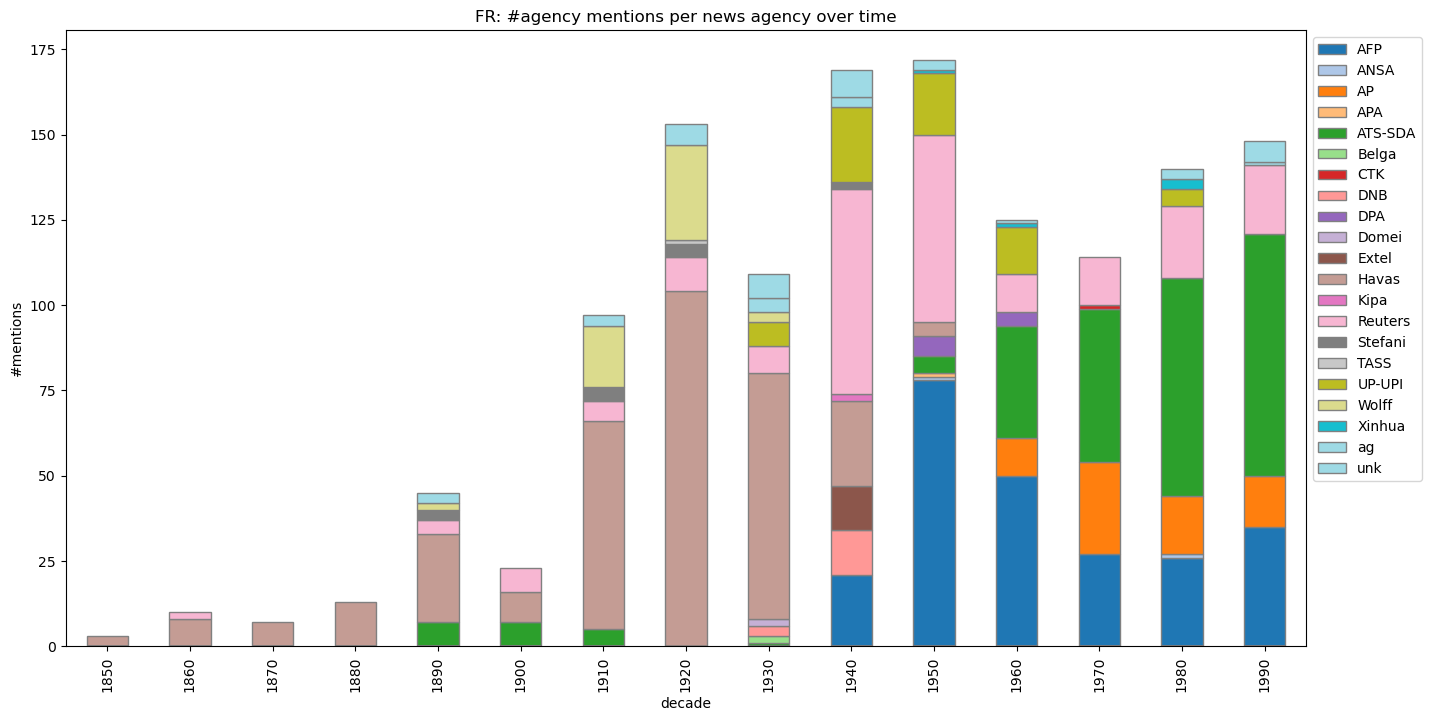

In [20]:
#German
na_per_decade_de = pd.pivot_table(mentions_de, index="decade", columns="ag_mention", values="document_id", aggfunc="count")
#no_agency_per_decade_de = no_mention_de.groupby(by="decade")[["document_id"]].count().rename(columns={"document_id": "no_agency"})
#na_per_decade_de = na_per_decade_de.join(no_agency_per_decade_de, how="outer")

na_per_decade_de.plot(kind="bar", stacked=True, figsize=(16,8), ylabel="#mentions", title="DE: #agency mentions per news agency over time", colormap='tab20', edgecolor="grey")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

#French
na_per_decade_fr = pd.pivot_table(mentions_fr, index="decade", columns="ag_mention", values="document_id", aggfunc="count")
#no_agency_per_decade_fr = no_mention_fr.groupby(by="decade")[["document_id"]].count().rename(columns={"document_id": "no_agency"})
#na_per_decade_fr = na_per_decade_fr.join(no_agency_per_decade_fr, how="outer")

na_per_decade_fr.plot(kind="bar", stacked=True, figsize=(16,8), ylabel="#mentions", title="FR: #agency mentions per news agency over time", colormap='tab20', edgecolor="grey")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

#Plot
plt.show()

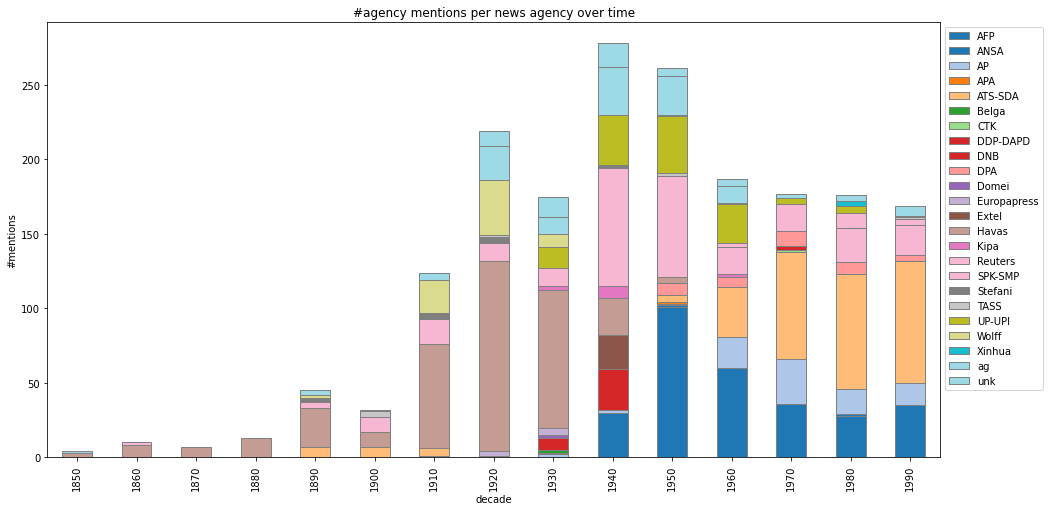

In [90]:
mentions = pd.concat([mentions_de, mentions_fr])
#no_mentions = pd.concat([no_mention_de, no_mention_fr])
na_per_decade = pd.pivot_table(mentions, index="decade", columns="ag_mention", values="document_id", aggfunc="count")
#no_agency_per_decade = no_mentions.groupby(by="decade")[["document_id"]].count().rename(columns={"document_id": "no_agency"})
#na_per_decade = na_per_decade.join(no_agency_per_decade, how="outer")

na_per_decade.plot(kind="bar", stacked=True, figsize=(16,8), ylabel="#mentions", title="#agency mentions per news agency over time", 
                   colormap='tab20', edgecolor="grey")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

## Distribution of Articles

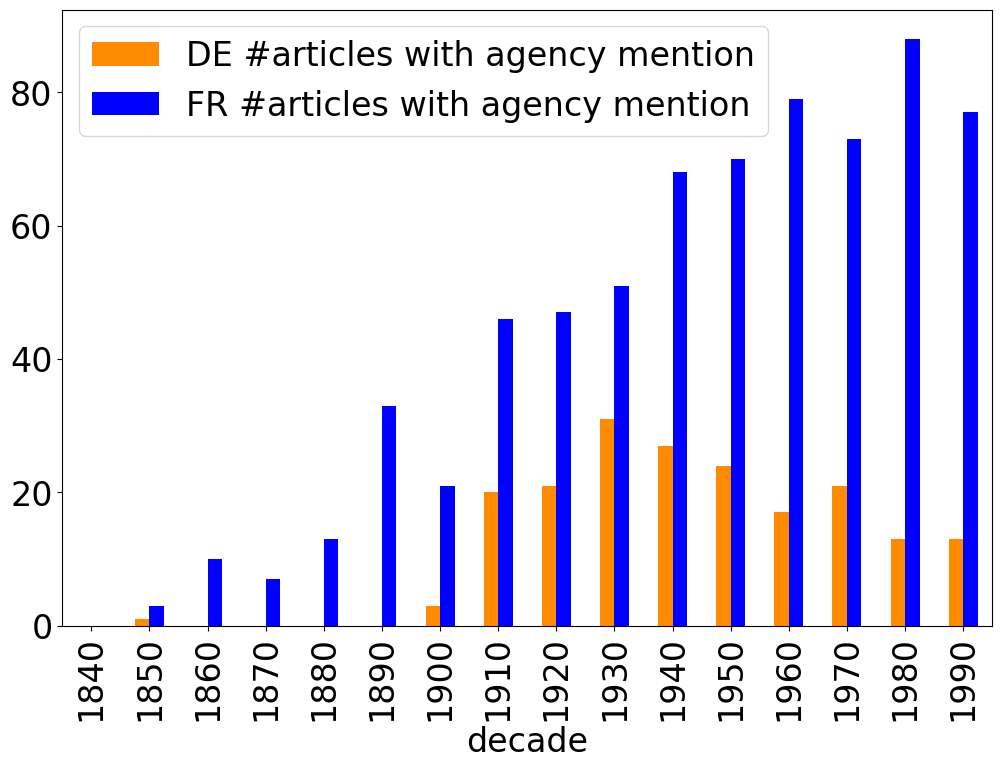

In [45]:
dec_count = articles_de.groupby("decade")[["document_id"]].count().rename(columns={"document_id": "DE #articles with agency mention"})
dec_count = dec_count.join(no_mention_de.groupby("decade")[["document_id"]].count().rename(columns={"document_id": "DE #articles no agency mention"}), how="outer")
dec_count = dec_count.join(articles_fr.groupby("decade")[["document_id"]].count().rename(columns={"document_id": "FR #articles with agency mention"}), how="outer")
dec_count = dec_count.join(no_mention_fr.groupby("decade")[["document_id"]].count().rename(columns={"document_id": "FR #articles no agency mention"}), how="outer")

dec_count.plot.bar(y=["DE #articles with agency mention", "FR #articles with agency mention"], figsize=(12,8), color=["darkorange", "blue"])
#plt.title("#articles per decade in training corpus")
plt.rcParams.update({'font.size': 24})

plt.show()

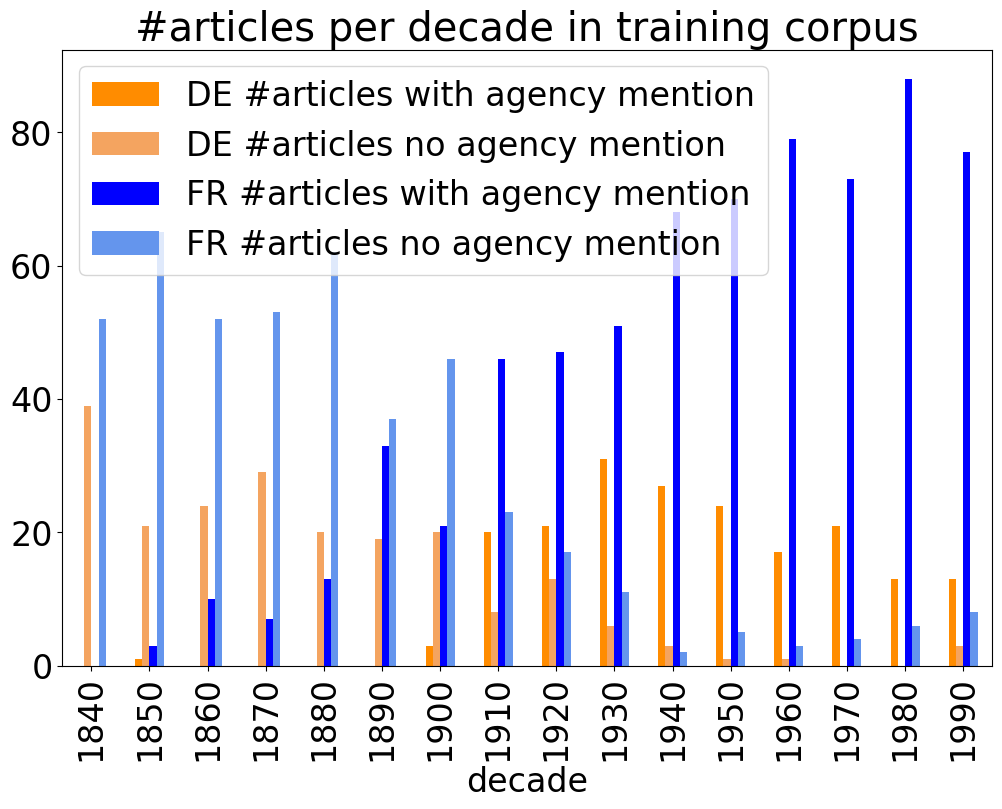

In [43]:
dec_count.plot.bar(figsize=(12,8), color=["darkorange", "sandybrown", "blue", "cornflowerblue"])
plt.title("#articles per decade in training corpus")
plt.show()

## Several Mentions per Article

In [22]:
articles_fr["number_ag_mentions"] = articles_fr["ag_mention"].apply(len)
articles_de["number_ag_mentions"] = articles_de["ag_mention"].apply(len)

In [23]:
print("FR", articles_fr["number_ag_mentions"].unique())
print("DE", articles_de["number_ag_mentions"].unique())

FR [ 1  5  3  4  2  6  8  7 24 10 11  9]
DE [ 6  3 10  2  5  4  1  7  8 11  9 15 17 14]


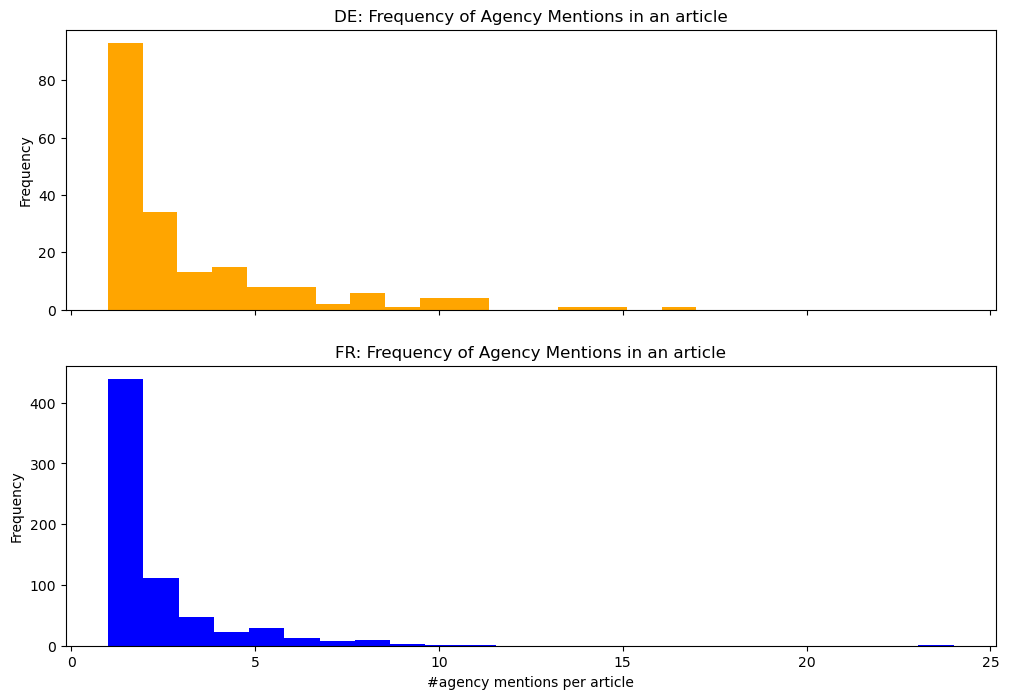

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12,8))
articles_de["number_ag_mentions"].plot.hist(ax=ax1, title="DE: Frequency of Agency Mentions in an article", 
                                            color="orange", bins=17)
articles_fr["number_ag_mentions"].plot.hist(ax=ax2, title="FR: Frequency of Agency Mentions in an article", 
                                            color="blue", bins=24)
ax2.set_xlabel("#agency mentions per article")
plt.show()

## Noisy OCR

In [25]:
mentions_fr["noisy_OCR"] = mentions_fr["levenshtein_dist"] > 0
mentions_de["noisy_OCR"] = mentions_de["levenshtein_dist"] > 0
mentions_de.head()

,document_id,year,decade,newspaper,document_size,language,split,ag_mention,ag_position,ag_at_beginning,ag_at_end,levenshtein_dist,ag_in_middle,noisy_OCR
0,buergerbeamten-1910-06-18-a-i0009,1910.0,1910,buergerbeamten,487.0,de,train,Wolff,423.0,0.0,0.0,0.15,1,True
0,buergerbeamten-1915-12-14-a-i0006,1915.0,1910,buergerbeamten,65.0,de,train,Havas,6.0,1.0,0.0,0.00,0,False
1,buergerbeamten-1915-12-14-a-i0006,1915.0,1910,buergerbeamten,65.0,de,train,Havas,60.0,0.0,1.0,0.00,0,False
0,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,train,UP-UPI,61.0,0.0,0.0,0.00,1,False
1,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,train,Extel,537.0,0.0,0.0,0.00,1,False


In [26]:
all_mentions = pd.concat([mentions_de, mentions_fr])
splits = ["train", "dev", "test"]

def get_noisy_ocr_percentage(df, split=None):
    if split:
        selection = df[df["split"]==split]
    else:
        selection = df.copy()
    return round(len(selection[selection['noisy_OCR']]) / len(selection) * 100)

for split in splits:
    print(f"DE - %noisy in {split} set: {get_noisy_ocr_percentage(mentions_de, split)} %")
    print(f"FR - %noisy in {split} set: {get_noisy_ocr_percentage(mentions_fr, split)} %")
    print(f"ALL - %noisy in {split} set: {get_noisy_ocr_percentage(all_mentions, split)} %\n")

print(f"\nDE - %noisy overall: {get_noisy_ocr_percentage(mentions_de)} %")
print(f"FR - %noisy overall: {get_noisy_ocr_percentage(mentions_fr)} %")
print(f"ALL - %noisy overall: {get_noisy_ocr_percentage(all_mentions)} %")

DE - %noisy in train set: 9 %
FR - %noisy in train set: 5 %
ALL - %noisy in train set: 6 %

DE - %noisy in dev set: 8 %
FR - %noisy in dev set: 3 %
ALL - %noisy in dev set: 4 %

DE - %noisy in test set: 3 %
FR - %noisy in test set: 7 %
ALL - %noisy in test set: 6 %


DE - %noisy overall: 9 %
FR - %noisy overall: 5 %
ALL - %noisy overall: 6 %


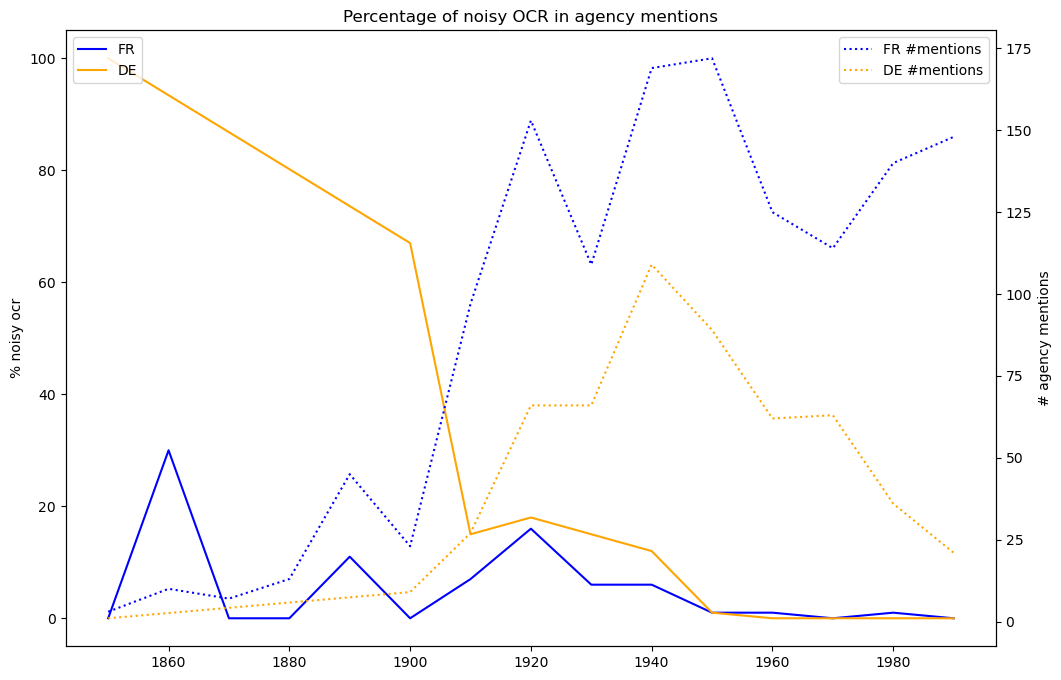

In [27]:
noisy_ocr_de = mentions_de.groupby("decade")["noisy_OCR"].agg(["count", "sum"]).rename(columns={"count": "total", "sum": "noisy_ocr"})
noisy_ocr_de["noisy_ocr_perc"] = noisy_ocr_de.apply(lambda row: round(row["noisy_ocr"] / row["total"] * 100), axis=1)

noisy_ocr_fr = mentions_fr.groupby("decade")["noisy_OCR"].agg(["count", "sum"]).rename(columns={"count": "total", "sum": "noisy_ocr"})
noisy_ocr_fr["noisy_ocr_perc"] = noisy_ocr_fr.apply(lambda row: round(row["noisy_ocr"] / row["total"] * 100), axis=1)

fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax1.plot(noisy_ocr_fr["noisy_ocr_perc"], label="FR", color="blue")
ax1.plot(noisy_ocr_de["noisy_ocr_perc"], label="DE", color="orange")

ax2 = ax1.twinx()
ax2.plot(noisy_ocr_fr["total"], label="FR #mentions", color="blue", linestyle="dotted")
ax2.plot(noisy_ocr_de["total"], label="DE #mentions", color="orange", linestyle="dotted")

plt.title("Percentage of noisy OCR in agency mentions")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("% noisy ocr")
ax2.set_ylabel("# agency mentions")
plt.show()

### check discarded files

In [30]:
from collections import Counter
log_path = "../../data/logs/"

with open(log_path + "discarded_de.txt", "r") as f:
    discarded_de = [f.strip() for f in f.readlines()]

with open(log_path + "discarded_fr.txt", "r") as f:
    discarded_fr = [f.strip() for f in f.readlines()]

print(f"#discarded in DE: {len(discarded_de)}")
print(f"#discarded in FR: {len(discarded_fr)}")

print("Examples for discarded:", discarded_de[:5])


#discarded in DE: 15
#discarded in FR: 65
Examples for discarded: ['buergerbeamten-1906-11-10-a-i0026', 'courriergdl-1867-08-29-a-i0024', 'LAB-1857-05-23-a-i0004', 'lunion-1863-03-13-a-i0024', 'lunion-1866-04-10-a-i0021']


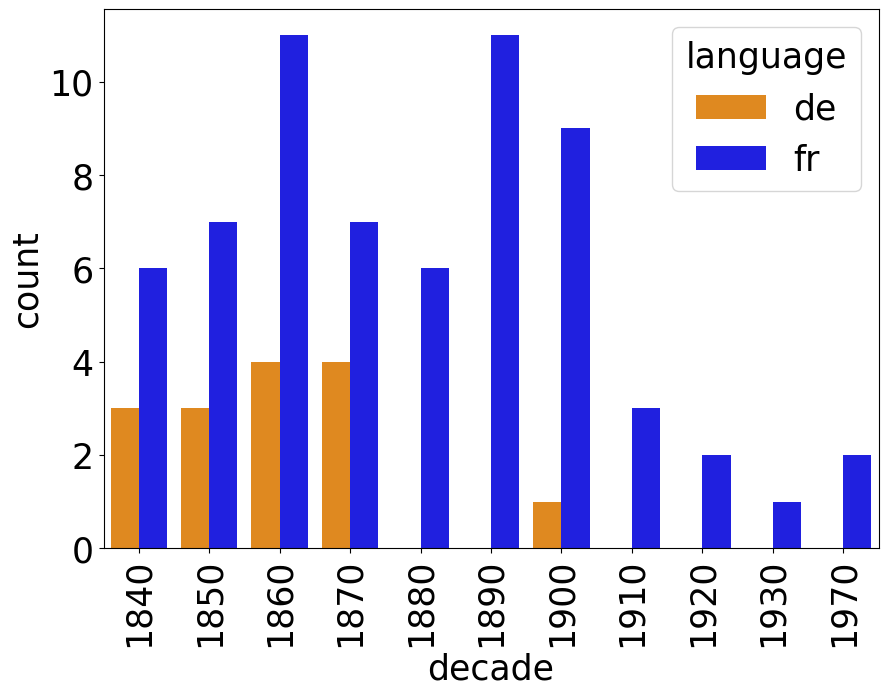

In [48]:
discarded_de_years = sorted([entry.split('-')[1] for entry in discarded_de])
discarded_fr_years = sorted([entry.split('-')[1] for entry in discarded_fr])
discarded_df = pd.concat([pd.DataFrame({"year": discarded_de_years, "language": "de"}), pd.DataFrame({"year": discarded_fr_years, "language": "fr"})])
discarded_df["decade"] = discarded_df["year"].apply(lambda x: int(x) //10 * 10)

countplt, ax = plt.subplots(figsize = (10,7))
sns.countplot(data=discarded_df, x="decade", hue="language", palette=["darkorange", "blue"])
plt.rcParams.update({'font.size': 24})
ax.tick_params(axis="x", rotation=90)

#plt.title("# Discarded documents due to noisy OCR")
plt.show()

## unk

In [32]:
unk_de = get_newsag_df("unk", docs_de_dir, docs_de)
unk_fr = get_newsag_df("unk", docs_fr_dir, docs_fr)

In [29]:
unk_de["name"].value_counts()

Telunion                                                 3
ADN                                                      2
Conti                                                    2
Tsch . P . V .                                           2
ATA                                                      2
Agence dAnatoiie                                         1
KNA                                                      1
Pm                                                       1
Agence Fournier                                          1
Petersburger Telegr . - Agentur .                        1
Petersburger Telegraphen - Agentur                       1
kaiserlich - lönigliche Wiener Korrespondenz - Bureau    1
Kori - esp . Bureau                                      1
rma                                                      1
Bernama News Agency                                      1
A . S .                                                  1
Interim                                                 

In [30]:
unk_fr["name"].value_counts()

Ofi                     3
B . C . H .             2
P . T . S .             2
Keystone                2
Red                     2
Press Association       2
C . N . B .             2
APF                     1
Dalziel                 1
APP                     1
ATQ                     1
CPS                     1
NDB                     1
OFI                     1
patriarche              1
I . P . S .             1
R . K .                 1
L . Bo                  1
Interinf                1
M . de B .              1
C . P .                 1
Chek lau                1
Pat                     1
Temps                   1
Daniel                  1
A . TE . P .            1
Telepress               1
B . P . Tchèque         1
Correspondenzbureaiv    1
R . F . P .             1
O . P . A .             1
Chekiai                 1
Name: name, dtype: int64

## Position of Agency Mentions

In [31]:
sum_mentions_de = len(mentions_de)
sum_mentions_fr = len(mentions_fr)

print("Statistics per Agency Mention")
print(f"DE: {round(sum(mentions_de['ag_at_beginning'])/sum_mentions_de*100)}% agency mentions at beginning, {round(sum(mentions_de['ag_in_middle'])/sum_mentions_de*100)}% in the middle, \
{round(sum(mentions_de['ag_at_end'])/sum_mentions_de*100)}% at end")
print(f"FR: {round(sum(mentions_fr['ag_at_beginning'])/sum_mentions_fr*100)}% agency mentions at beginning, {round(sum(mentions_fr['ag_in_middle'])/sum_mentions_fr*100)}% in the middle, \
{round(sum(mentions_fr['ag_at_end'])/sum_mentions_fr*100)}% at end")

Statistics per Agency Mention
DE: 4% agency mentions at beginning, 86% in the middle, 10% at end
FR: 3% agency mentions at beginning, 74% in the middle, 23% at end


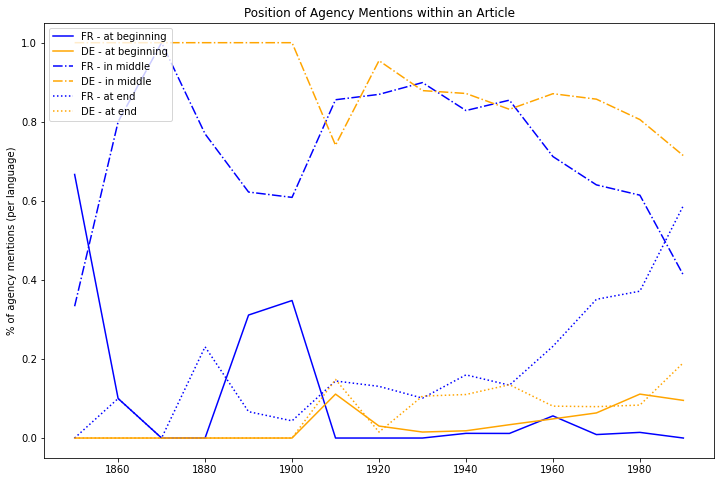

In [43]:
mention_pos_de = mentions_de.groupby("decade")[["ag_at_beginning", "ag_at_end", "ag_in_middle"]].agg(["mean"])
mention_pos_fr = mentions_fr.groupby("decade")[["ag_at_beginning", "ag_at_end", "ag_in_middle"]].agg(["mean"])

fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax1.plot(mention_pos_fr["ag_at_beginning"]["mean"], label="FR - at beginning", color="blue")
ax1.plot(mention_pos_de["ag_at_beginning"]["mean"], label="DE - at beginning", color="orange")
ax1.plot(mention_pos_fr["ag_in_middle"]["mean"], label="FR - in middle", color="blue", linestyle="dashdot")
ax1.plot(mention_pos_de["ag_in_middle"]["mean"], label="DE - in middle", color="orange", linestyle="dashdot")
ax1.plot(mention_pos_fr["ag_at_end"]["mean"], label="FR - at end", color="blue", linestyle="dotted")
ax1.plot(mention_pos_de["ag_at_end"]["mean"], label="DE - at end", color="orange", linestyle="dotted")

plt.title("Position of Agency Mentions within an Article")
ax1.legend(loc="upper left")
ax1.set_ylabel("% of agency mentions (per language)")
plt.show()

In [30]:
sum_articles_de = len(articles_de)
sum_articles_fr = len(articles_fr)

lambda_exp = lambda row: 1 if sum(row) > 0 else 0

print("Statistics per Article (several agency mentions in one article possible)")
print(f"DE: {round(sum(articles_de['ag_at_beginning'].apply(lambda_exp))/sum_articles_de*100)}% of articles have agency mentions at beginning, \
{round(sum(articles_de['ag_in_middle'].apply(lambda_exp))/sum_articles_de*100)}% in the middle, \
{round(sum(articles_de['ag_at_end'].apply(lambda_exp))/sum_articles_de*100)}% at end")
print(f"FR: {round(sum(articles_fr['ag_at_beginning'].apply(lambda_exp))/sum_articles_fr*100)}% of articles have agency mentions at beginning, \
{round(sum(articles_fr['ag_in_middle'].apply(lambda_exp))/sum_articles_fr*100)}% in the middle, \
{round(sum(articles_fr['ag_at_end'].apply(lambda_exp))/sum_articles_fr*100)}% at end")

Statistics per Article (several agency mentions in one article possible)
DE: 12% of articles have agency mentions at beginning, 88% in the middle, 22% at end
FR: 6% of articles have agency mentions at beginning, 70% in the middle, 37% at end


C:\Users\Lea\AppData\Local\Temp/ipykernel_14728/3286550004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_one_mention_de[["ag_at_beginning", "ag_at_end", "ag_in_middle"]] = articles_one_mention_de[["ag_at_beginning", "ag_at_end", "ag_in_middle"]].apply(lambda col: col.str[0])
C:\Users\Lea\AppData\Local\Temp/ipykernel_14728/3286550004.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_one_mention_fr[["ag_at_beginning", "ag_at_end", "ag_in_middle"]] = articles_one_mention_fr[["ag_at_be

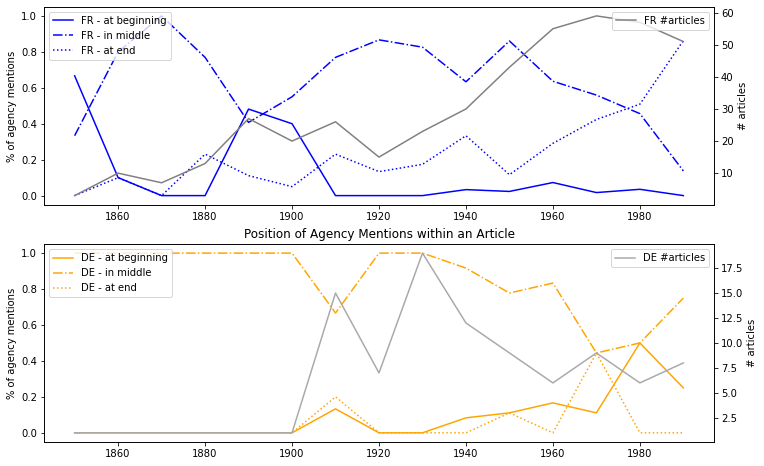

In [64]:
articles_one_mention_de = articles_de[articles_de["number_ag_mentions"]==1]
articles_one_mention_de[["ag_at_beginning", "ag_at_end", "ag_in_middle"]] = articles_one_mention_de[["ag_at_beginning", "ag_at_end", "ag_in_middle"]].apply(lambda col: col.str[0])
article_pos_de = articles_one_mention_de.groupby("decade")[["document_id", "ag_at_beginning", "ag_at_end", "ag_in_middle"]].agg(
    {"document_id": ["count"], "ag_at_beginning": ["mean"], "ag_in_middle": ["mean"], "ag_at_end": ["mean"]})

articles_one_mention_fr = articles_fr[articles_fr["number_ag_mentions"]==1]
articles_one_mention_fr[["ag_at_beginning", "ag_at_end", "ag_in_middle"]] = articles_one_mention_fr[["ag_at_beginning", "ag_at_end", "ag_in_middle"]].apply(lambda col: col.str[0])
article_pos_fr = articles_one_mention_fr.groupby("decade")[["document_id", "ag_at_beginning", "ag_at_end", "ag_in_middle"]].agg(
    {"document_id": ["count"], "ag_at_beginning": ["mean"], "ag_in_middle": ["mean"], "ag_at_end": ["mean"]})

##plotting
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(12)
ax1.plot(article_pos_fr["ag_at_beginning"]["mean"], label="FR - at beginning", color="blue")
ax2.plot(article_pos_de["ag_at_beginning"]["mean"], label="DE - at beginning", color="orange")
ax1.plot(article_pos_fr["ag_in_middle"]["mean"], label="FR - in middle", color="blue", linestyle="dashdot")
ax2.plot(article_pos_de["ag_in_middle"]["mean"], label="DE - in middle", color="orange", linestyle="dashdot")
ax1.plot(article_pos_fr["ag_at_end"]["mean"], label="FR - at end", color="blue", linestyle="dotted")
ax2.plot(article_pos_de["ag_at_end"]["mean"], label="DE - at end", color="orange", linestyle="dotted")


ax12 = ax1.twinx()
ax22 = ax2.twinx()
ax12.plot(article_pos_fr["document_id"]["count"], label="FR #articles", color="grey")
ax22.plot(article_pos_de["document_id"]["count"], label="DE #articles", color="darkgrey")


plt.title("Position of Agency Mentions within an Article")
ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
ax12.legend(loc="upper right")
ax22.legend(loc="upper right")
ax1.set_ylabel("% of agency mentions")
ax2.set_ylabel("% of agency mentions")
ax12.set_ylabel("# articles")
ax22.set_ylabel("# articles")
plt.show()

## Stats on Sentence Lengths

In [10]:
test_df = tsv_to_dataframe(join(docs_de_dir, docs_de[0]), keep_comments=True, hipe_format_version="v2")
print(test_df["SEG"].unique())

['_' 'EndOfSentence']


In [94]:
sents_i = [0] + test_df[test_df["SEG"]=="EndOfSentence"].index.to_list()
sents_len = {(sents_i[i], sents_i[i+1]): sents_i[i+1] - sents_i[i] for i in range(len(sents_i)-1)}
sents_len_128 = [k for k,v in sents_len.items() if v >= 128]
for beg, end in sents_len_128:
    if any(test_df.loc[beg+128:end, "NE-FINE-LIT"].str.contains("agency")):
        rows = test_df.iloc[beg+128:end]
        print(rows[rows["NE-FINE-LIT"].str.contains("agency")]["NE-FINE-LIT"])

In [69]:
len(test_df)

2140

In [103]:
def get_sentence_lengths(df, cutoff=128):
    """  
    Returns list of all sentence lengths of a Dataframe. Also prints agency mentions, if their position in the
    sentence is higher than the cutoff value.
    """

    #get the position of all EndOFSentence tags in the document
    sents_i = [0] + df[df["SEG"]=="EndOfSentence"].index.to_list()
    #compute the length of each sentence, saving the beginning and end position as keys and the length as values
    sents_len = {(sents_i[i], sents_i[i+1]): sents_i[i+1] - sents_i[i] for i in range(len(sents_i)-1)}

    #save all sentences with length higher than the cutoff value
    sents_len_128 = [k for k,v in sents_len.items() if v >= cutoff]

    for beg, end in sents_len_128:
        #check if long sentences contain an agency mention at position higher than the cutoff value
        if any(df.loc[beg+cutoff : end, "NE-FINE-LIT"].str.contains("agency")):
            rows = df.iloc[beg+cutoff : end]
            ag_mention = rows[rows["NE-FINE-LIT"].str.contains("agency")].copy()
            ag_mention["position"] = ag_mention.index - beg
            print(ag_mention[["position", "NE-FINE-LIT"]])

    return list(sents_len.values())


In [104]:
sent_len_de_train, sent_len_de_dev, sent_len_de_test = [], [], []

for doc in docs_de:
    doc_path = join(docs_de_dir, doc)
    cur_df = tsv_to_dataframe(doc_path, keep_comments=True, hipe_format_version="v2")
    split = split_de.loc[cur_df["document_id"], "split"].values[0]
    
    if split == "train":
        sent_len_de_train += get_sentence_lengths(cur_df, 128)
    elif split == "dev":
        sent_len_de_dev += get_sentence_lengths(cur_df, 128)
    elif split == "test":
        sent_len_de_test += get_sentence_lengths(cur_df, 128)
    else:
        print("Split not found.")

sent_len_de = np.array(sent_len_de_train + sent_len_de_dev + sent_len_de_test)
sent_len_de_train, sent_len_de_dev, sent_len_de_test = np.array(sent_len_de_train), np.array(sent_len_de_dev), np.array(sent_len_de_test)

     position               NE-FINE-LIT
593       367  B-org.ent.pressagency.ag
594       368  I-org.ent.pressagency.ag
      position               NE-FINE-LIT
880        206  B-org.ent.pressagency.ag
881        207  I-org.ent.pressagency.ag
964        290  B-org.ent.pressagency.ag
965        291  I-org.ent.pressagency.ag
1062       388  B-org.ent.pressagency.ag
1063       389  I-org.ent.pressagency.ag
1188       514  B-org.ent.pressagency.ag
1189       515  I-org.ent.pressagency.ag
     position                  NE-FINE-LIT
328       273     B-org.ent.pressagency.ag
329       274     I-org.ent.pressagency.ag
331       276  B-org.ent.pressagency.Havas
     position                    NE-FINE-LIT
247       184  B-org.ent.pressagency.ATS-SDA
249       186  B-org.ent.pressagency.Reuters
     position                    NE-FINE-LIT
437       140  B-org.ent.pressagency.ATS-SDA
439       142      B-org.ent.pressagency.AFP
     position                 NE-FINE-LIT
190       179  B-org.ent.pr

In [106]:
sent_len_fr_train, sent_len_fr_dev, sent_len_fr_test = [], [], []

for doc in docs_fr:
    doc_path = join(docs_fr_dir, doc)
    cur_df = tsv_to_dataframe(doc_path, keep_comments=True, hipe_format_version="v2")
    split = split_fr.loc[cur_df["document_id"], "split"].values[0]
    
    if split == "train":
        sent_len_fr_train += get_sentence_lengths(cur_df)
    elif split == "dev":
        sent_len_fr_dev += get_sentence_lengths(cur_df)
    elif split == "test":
        sent_len_fr_test += get_sentence_lengths(cur_df)
    else:
        print("Split not found.")

sent_len_fr = np.array(sent_len_fr_train + sent_len_fr_dev + sent_len_fr_test)
sent_len_fr_train, sent_len_fr_dev, sent_len_fr_test = np.array(sent_len_fr_train), np.array(sent_len_fr_dev), np.array(sent_len_fr_test)

      position                  NE-FINE-LIT
1675       304  B-org.ent.pressagency.Havas
1724       353  B-org.ent.pressagency.Havas
      position                  NE-FINE-LIT
1197       209  B-org.ent.pressagency.Wolff
     position                    NE-FINE-LIT
278       276    B-org.ent.pressagency.Wolff
500       498    B-org.ent.pressagency.Wolff
555       553  B-org.ent.pressagency.Stefani
     position                  NE-FINE-LIT
164       164  B-org.ent.pressagency.Havas
     position                  NE-FINE-LIT
814       151  B-org.ent.pressagency.Havas
888       225  B-org.ent.pressagency.Havas
     position                  NE-FINE-LIT
299       188  B-org.ent.pressagency.Havas
365       254  B-org.ent.pressagency.Havas
504       393  B-org.ent.pressagency.Havas
756       645  B-org.ent.pressagency.Havas
     position                  NE-FINE-LIT
379       264  B-org.ent.pressagency.Havas
650       535  B-org.ent.pressagency.Havas
708       593  B-org.ent.pressagency.Hava

In [105]:
pd.DataFrame(sent_len_de).describe()

,0
count,12843.000000
mean,23.502141
std,47.926775
min,1.000000
25%,5.000000
50%,12.000000
75%,25.000000
max,1057.000000


In [108]:
pd.DataFrame(sent_len_fr).describe()

,0
count,29127.000000
mean,25.371408
std,51.307558
min,0.000000
25%,7.000000
50%,16.000000
75%,30.000000
max,1808.000000


In [109]:
print("Sentence length percentiles for de dataset:")
for perc in range(90,100):
    print(f"{perc}%: {np.percentile(sent_len_de, perc)}")
print("length of 20 longest sentences in de dataset:", sorted(sent_len_de)[-20:])

Sentence length percentiles for de dataset:
90%: 45.0
91%: 48.0
92%: 51.0
93%: 56.06000000000131
94%: 63.0
95%: 71.0
96%: 86.0
97%: 109.73999999999978
98%: 145.0
99%: 225.0
length of 20 longest sentences in de dataset: [521, 535, 563, 576, 578, 596, 599, 606, 668, 699, 713, 722, 731, 731, 738, 856, 924, 967, 981, 1057]


In [110]:
print("Sentence length percentiles for de dataset:")
percentiles = list(range(90,100)) + [99.5, 99.7, 99.8, 99.9]
for perc in percentiles:
    print(f"{perc}%: {np.percentile(sent_len_fr, perc)}")
print("length of 20 longest sentences in fr dataset:", sorted(sent_len_fr)[-20:])

Sentence length percentiles for de dataset:
90%: 47.0
91%: 49.0
92%: 52.0
93%: 54.0
94%: 58.0
95%: 62.0
96%: 69.0
97%: 79.0
98%: 98.0
99%: 165.73999999999796
99.5%: 302.369999999999
99.7%: 406.86599999999817
99.8%: 592.4959999999992
99.9%: 763.6220000000103
length of 20 longest sentences in fr dataset: [830, 834, 835, 837, 890, 1016, 1081, 1091, 1115, 1147, 1177, 1216, 1244, 1300, 1300, 1338, 1381, 1583, 1763, 1808]


## Working with Release Dataset

In [73]:
RELEASE_VERSION = "2"
newsag_data_path = f"../data/release/{RELEASE_VERSION}/"
stats_path = f"{newsag_data_path}/stats/"

In [74]:
# DE
newsag_train_de_path = os.path.join(newsag_data_path, f"de/newsagency-data-{RELEASE_VERSION}-train-de.tsv")
newsag_dev_de_path = os.path.join(newsag_data_path, f"de/newsagency-data-{RELEASE_VERSION}-dev-de.tsv")
newsag_test_de_path = os.path.join(newsag_data_path, f"de/newsagency-data-{RELEASE_VERSION}-test-de.tsv")

# FR
newsag_train_fr_path = os.path.join(newsag_data_path, f"fr/newsagency-data-{RELEASE_VERSION}-train-fr.tsv")
newsag_dev_fr_path = os.path.join(newsag_data_path, f"fr/newsagency-data-{RELEASE_VERSION}-dev-fr.tsv")
newsag_test_fr_path = os.path.join(newsag_data_path, f"fr/newsagency-data-{RELEASE_VERSION}-test-fr.tsv")

## Stats per agency

In [75]:
stats_datasets = {
    "stats_train_de": newsag_train_de_path,
    "stats_dev_de": newsag_dev_de_path,
    "stats_test_de": newsag_test_de_path,
    "stats_train_fr": newsag_train_fr_path,
    "stats_dev_fr": newsag_dev_fr_path,
    "stats_test_fr": newsag_test_fr_path
}
if not os.path.exists(stats_path):
    os.makedirs(stats_path)

for name, path in stats_datasets.items():
    # parse the TSV into a list of `HipeDocument` objects
    selection_docs = parse_tsv(file_path=path)
    # compute some basic stats for the TSV dataset 
    selection_stats = describe_dataset(documents=selection_docs)

    with open(f"{stats_path}{name}.txt", "w") as f:
        f.write(selection_stats)
        print(f"Wrote {name} to {stats_path}")    

Wrote stats_train_de to ../data/release/2//stats/
Wrote stats_dev_de to ../data/release/2//stats/
Wrote stats_test_de to ../data/release/2//stats/
Wrote stats_train_fr to ../data/release/2//stats/
Wrote stats_dev_fr to ../data/release/2//stats/
Wrote stats_test_fr to ../data/release/2//stats/


## General Stats for Train/Dev/Test Set

In [76]:
# slightly modified version of the original function
def count_entities(docs: List[HipeDocument], exclude_from_NIL: List[str] = []) -> Dict:

    counts = {}
    
    for e_type in ENTITY_TYPES:
        for doc in docs:
            if e_type in doc.entities:
                if e_type not in counts:
                    counts[e_type] = 0
                counts[e_type] += len(doc.entities[e_type])
                
    # count the NIL entities
    # TODO: for ajmc, exclude from counts those that are not
    # supposed to be linked as per participation guidelines
                
    nil_entities_count = 0
    wikidata_linked_count = 0
    nonlinked_count = 0
    noisy_entities_count = 0
    for doc in docs:
        
        if not 'coarse_lit' in doc.entities:
            continue
        
        for entity in doc.entities['coarse_lit']:
            #print(entity.wididata_id)
            if entity.wikidata_id is not None:
                if entity.wikidata_id == "NIL":
                    
                    if entity.tag in exclude_from_NIL:
                        nonlinked_count += 1
                    else:
                        nil_entities_count += 1
                
                elif entity.wikidata_id != "NIL":
                    wikidata_linked_count += 1
            else:
                nonlinked_count += 1

            #does not work - computed in section OCR noise    
            #if entity.LED and entity.LED > 0:
            #    noisy_entities_count += 1
                
    counts['nil'] = nil_entities_count
    counts['wikidata_link'] = wikidata_linked_count
    counts['non_linked'] = nonlinked_count
    counts['noisy'] = noisy_entities_count
    return counts



def compute_dataset_stats(**kwargs):
    if "file_path" in kwargs:
        path = kwargs['file_path']
        docs = parse_tsv(file_path=path)
    elif "file_url" in kwargs:
        path = kwargs['file_url']
        docs = parse_tsv(file_url=path)
    elif "documents" in kwargs:
        docs = kwargs['documents']
        path = docs[0].path
    else:
        raise
        
    total_n_tokens = sum([
        doc.n_tokens
        for doc in docs
    ])
    
    entity_counts = count_entities(docs, exclude_from_NIL=['time'])
        
    data = {
        "n_docs": len(docs),
        "total_n_tokens": total_n_tokens,
        "n_mentions": entity_counts['coarse_lit'],
        "n_nested": entity_counts['nested'] if 'nested' in entity_counts else None,
        "n_nil": entity_counts['nil'],
        "n_wikidata_link": entity_counts['wikidata_link'],
        "n_linkable_mentions": entity_counts['coarse_lit'] - entity_counts['non_linked'],
        "n_non_linked": entity_counts['non_linked'],
        "n_noisy": entity_counts['noisy']
    }
    
    return pd.DataFrame([data])

In [77]:
stats_df = pd.DataFrame()
for name, path in stats_datasets.items():
    selection_stats = compute_dataset_stats(file_path=path)
    selection_stats.insert(0, "set", name)
    stats_df = pd.concat([stats_df, selection_stats])

#add stats per split
for split in splits:
    selection_stats = stats_df[stats_df["set"].str.contains(split)]
    selection_stats = selection_stats.sum()
    selection_stats["set"] = split
    stats_df = stats_df.append(selection_stats, ignore_index=True)

#add stats per language
for lang in ["de", "fr"]:
    selection_stats = stats_df[stats_df["set"].str.contains(f"_[a-z]+_{lang}")]
    selection_stats = selection_stats.sum()
    selection_stats["set"] = lang
    stats_df = stats_df.append(selection_stats, ignore_index=True)

#add total
selection_stats = stats_df[stats_df["set"].isin(splits)]
selection_stats = selection_stats.sum()
selection_stats["set"] = "all"
stats_df = stats_df.append(selection_stats, ignore_index=True)

C:\Users\Lea\AppData\Local\Temp/ipykernel_14728/4270088799.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(selection_stats, ignore_index=True)
C:\Users\Lea\AppData\Local\Temp/ipykernel_14728/4270088799.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(selection_stats, ignore_index=True)
C:\Users\Lea\AppData\Local\Temp/ipykernel_14728/4270088799.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(selection_stats, ignore_index=True)


In [79]:
stats_df

,set,n_docs,total_n_tokens,n_mentions,n_nested,n_nil,n_wikidata_link,n_linkable_mentions,n_non_linked,n_noisy
0,stats_train_de,296,221604,427,None,6,284,290,137,0
1,stats_dev_de,30,27215,23,None,1,16,17,6,0
2,stats_test_de,32,22437,58,None,1,35,36,22,0
3,stats_train_fr,892,600332,1113,None,0,975,975,138,0
4,stats_dev_fr,110,77746,114,None,0,105,105,9,0
5,stats_test_fr,120,75057,163,None,0,141,141,22,0
6,train,1188,821936,1540,0,6,1259,1265,275,0
7,dev,140,104961,137,0,1,121,122,15,0
8,test,152,97494,221,0,1,176,177,44,0
9,de,358,271256,508,0,8,335,343,165,0


In [83]:
#add noisy OCR stats
noisy_info = {
    "stats_train_de": (mentions_de, "train"),
    "stats_dev_de": (mentions_de, "dev"),
    "stats_test_de": (mentions_de, "test"),
    "stats_train_fr": (mentions_fr, "train"),
    "stats_dev_fr": (mentions_fr, "dev"),
    "stats_test_fr": (mentions_fr, "test"),
    "train": (all_mentions, "train"),
    "dev": (all_mentions, "dev"),
    "test": (all_mentions, "test"),
    "de": (mentions_de, None),
    "fr": (mentions_fr, None),
    "all": (all_mentions, None)
}

for set, (df, split) in noisy_info.items():
    stats_df["n_noisy"][stats_df["set"] == set] = get_noisy_ocr_percentage(df, split)

stats_df

C:\Users\Lea\AppData\Local\Temp/ipykernel_14728/3059526872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df["n_noisy"][stats_df["set"] == set] = get_noisy_ocr_percentage(df, split)


,set,n_docs,total_n_tokens,n_mentions,n_nested,n_nil,n_wikidata_link,n_linkable_mentions,n_non_linked,n_noisy
0,stats_train_de,296,221604,427,None,6,284,290,137,9
1,stats_dev_de,30,27215,23,None,1,16,17,6,8
2,stats_test_de,32,22437,58,None,1,35,36,22,3
3,stats_train_fr,892,600332,1113,None,0,975,975,138,5
4,stats_dev_fr,110,77746,114,None,0,105,105,9,3
5,stats_test_fr,120,75057,163,None,0,141,141,22,7
6,train,1188,821936,1540,0,6,1259,1265,275,6
7,dev,140,104961,137,0,1,121,122,15,4
8,test,152,97494,221,0,1,176,177,44,6
9,de,358,271256,508,0,8,335,343,165,9


In [84]:
#save to csv
stats_df.to_csv(f"{stats_path}global_stats.csv")

## Stats on Missed Annotations

In [91]:
missed_ann = pd.DataFrame({"language" : ["de", "fr", "all"],
             "modified articles" : [12, 64, 58],
             "modified mentions" : [14, 71, 85],
             "total mentions": [508, 1390, 1898]})
missed_ann["% missed mentions"] = missed_ann["modified mentions"] / missed_ann["total mentions"] * 100
missed_ann

,language,modified articles,modified mentions,total mentions,% missed mentions
0,de,12,14,508,2.755906
1,fr,64,71,1390,5.107914
2,all,58,85,1898,4.478398
